## Import Libraries

     |████████████████████████████████| 77 kB 3.8 MB/s eta 0:00:011
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61085 sha256=246bdc6f1a2ac93e2665ed034bc142e87473daba58c1de994b8b668ae1d2fdda
  Stored in directory: /Users/juliya/Library/Caches/pip/wheels/b1/1a/8f/a4c34be976825a2f7948d0fa40907598d69834f8ab5889de11
Successfully built PyPDF2
Note: you may need to restart the kernel to use updated packages.


In [1]:
# importing the necessary modules
import requests
from bs4 import BeautifulSoup
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import os
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from pandasql import sqldf
import pandasql as psql
import missingno as msno
from scipy import stats
from scipy.stats import pearsonr
sns.set(color_codes=True)
import statsmodels.api as sm  
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.datasets import load_iris
import plotnine as p9 
import re
from PyPDF2 import PdfFileReader

In [2]:
# Abbeviations and Details of Column Names
#Agency AGYSUB TEXT
#Location LOC TEXT
#Age AGELVL TEXT
#Education Level EDLVL TEXT
#General Schedule & Equivalent Grade GSEGRD TEXT
#Length of Service LOSLVL TEXT
#Occupation OCC TEXT
#Occupation Category PATCO TEXT
#Pay Plan & Grade PPGRD TEXT
#Salary Level SALLVL TEXT
#STEM Occupations STEMOCC TEXT
#Supervisory Status SUPERVIS TEXT
#Type Appointment TOA TEXT
#Work Schedule WORKSCH TEXT
#Work Status WORKSTAT TEXT
#Date (e.g. 202109) DATECODE TEXT
#Employment EMPLOYMENT NUMERIC
#Average Salary SALARY NUMERIC
#Average  LOS NUMERIC

## Data Import

In [3]:
#Set variable for page to be opened and url to be concatenated 
page =requests.get('https://www.opm.gov/data/index.aspx')
baseurl= 'https://www.opm.gov/'
#Use BeautifulSoup to clean up the page
soup = BeautifulSoup(page.text, "html.parser")
soup.prettify()

# Creating a new file to store the zip file links
newfile = open('zipfiles.txt','w')
#Find all the links on the page that end in .zip and write them into the text file
for anchor in soup.findAll('a', href=True):
    links = anchor['href']
    if links.endswith('.zip'):
        newfile.write(links + '\n')
newfile.close()

## Automate zipfile download and extract

In [4]:
#Fetching the links for the zip file and downloading the files
with open('zipfiles.txt', 'r') as links:
    count = 0
    for link in links:
        if count == 2:
            break
        if link:
            filename1= link.split('/')[-1]
            filename= filename1[:-1]
            link = baseurl + link
            print(filename + ' file started to download')
            response = requests.get(link[:-1])
            
            # Writing the zip file into local file system
            with open(filename,'wb') as output_file:
                output_file.write(response.content)
            print(filename + ' file is downloaded')
            with ZipFile(filename, 'r') as zip:
                # printing all the contents of the zip file
                #zip.printdir()
                print('')
            z = ZipFile(BytesIO(response.content))
            # gets September data
            if count == 0:
                def new_directory(directory, filename):
                  # Before creating a new directory, check to see if it already exists
                  if os.path.isdir(directory) == False:
                    os.mkdir(directory)
                #print(directory+" "+filename)
                z.extractall('SepData')
                print('September data Extracted')
                print('-------------------------------------------------------------')
            # gets June data    
            elif count == 1:
                def new_directory(directory, filename):
                  # Before creating a new directory, check to see if it already exists
                  if os.path.isdir(directory) == False:
                    os.mkdir('JunData')
                z.extractall('JunData')
                print('June data Extracted')
            count += 1
            

5f8e430d-fb84-4856-a25b-81f6dcc0eb7f.zip file started to download
5f8e430d-fb84-4856-a25b-81f6dcc0eb7f.zip file is downloaded

September data Extracted
-------------------------------------------------------------
9a772b04-cab4-4b89-b62a-a3859371cb13.zip file started to download
9a772b04-cab4-4b89-b62a-a3859371cb13.zip file is downloaded

June data Extracted


### Merge the datasets

In [5]:
# Importing September data using pandas
FACTDATA_S = pd.read_csv("FEC092021/FACTDATA_SEP2021.txt")
# Importing June data using pandas
FACTDATA_J = pd.read_csv("FEC062021/FACTDATA_JUN2021.txt")
#merge data of both Sep and June using pandas
data = pd.concat([FACTDATA_S, FACTDATA_J], axis=0)
data

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,4,6,8,12,13) have mixed types.Specify dtype option on import or set low_memory=False.


,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
0,AA00,11,F,13,NaN,F,0340,2,ES,ES-**,S,XXXX,2,50,F,1,202109,1,192500.0,18.3
1,AA00,11,I,15,NaN,H,0905,1,ES,ES-**,R,XXXX,2,50,F,1,202109,1,187000.0,28.7
2,AA00,11,E,15,15,E,0905,1,99,GS-15,Q,XXXX,2,30,F,1,202109,1,172500.0,12.0
3,AA00,11,E,15,15,E,0905,1,99,GS-15,N,XXXX,8,30,F,1,202109,1,144128.0,10.0
4,AA00,11,F,15,13,E,0905,1,99,GS-13,K,XXXX,8,30,F,1,202109,1,114059.0,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188918,ZS00,11,I,01,NaN,A,0301,2,99,AD-00,Q,XXXX,8,48,I,2,202106,1,173074.0,0.3
2188919,ZS00,11,C,17,NaN,A,0301,2,99,AD-00,E,XXXX,8,48,F,2,202106,1,57000.0,0.1
2188920,ZU00,11,K,17,NaN,E,0301,2,99,AD-00,Q,XXXX,8,48,F,2,202106,1,170800.0,14.1
2188921,ZU00,11,E,17,NaN,D,0301,2,99,AD-00,K,XXXX,8,38,F,1,202106,1,112930.0,8.0


# Data Cleaning

In [6]:
# Finding the type of each variable in the dataset
#data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4379934 entries, 0 to 2188922
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   AGYSUB      object 
 1   LOC         object 
 2   AGELVL      object 
 3   EDLVL       object 
 4   GSEGRD      object 
 5   LOSLVL      object 
 6   OCC         object 
 7   PATCO       int64  
 8   PP          object 
 9   PPGRD       object 
 10  SALLVL      object 
 11  STEMOCC     object 
 12  SUPERVIS    object 
 13  TOA         object 
 14  WORKSCH     object 
 15  WORKSTAT    int64  
 16  DATECODE    int64  
 17  EMPLOYMENT  int64  
 18  SALARY      float64
 19  LOS         float64
dtypes: float64(2), int64(4), object(14)
memory usage: 701.7+ MB


### Missing Values

In [7]:
# Sum of null values in each Attribute
#data.isnull().sum()

#Missing data in % values
data.isnull().sum()/(len(data))*100

AGYSUB         0.000000
LOC            0.000000
AGELVL         0.000000
EDLVL          0.216464
GSEGRD        29.266879
LOSLVL         0.000000
OCC            0.000000
PATCO          0.000000
PP             0.000000
PPGRD          0.000000
SALLVL         0.000000
STEMOCC        0.000000
SUPERVIS       0.000000
TOA            0.000000
WORKSCH        0.000000
WORKSTAT       0.000000
DATECODE       0.000000
EMPLOYMENT     0.000000
SALARY        13.435294
LOS            0.000845
dtype: float64

<AxesSubplot:>

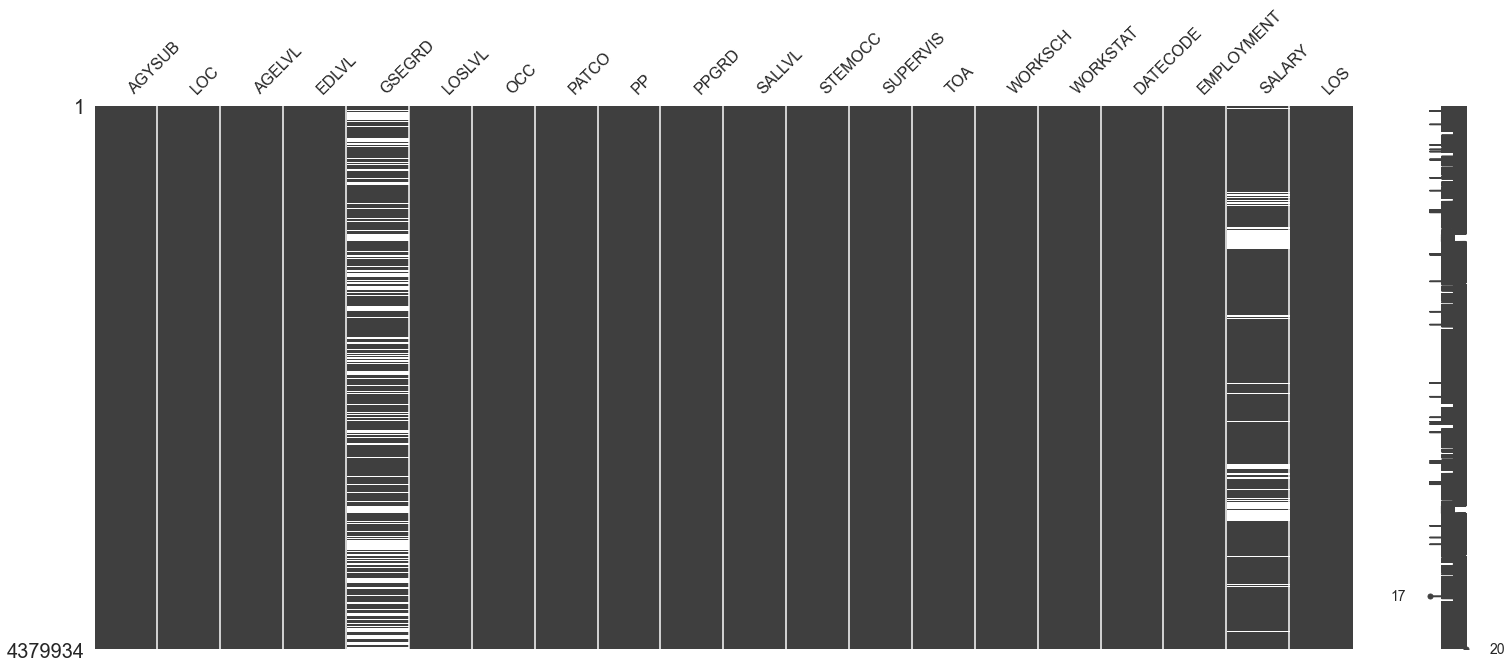

In [8]:
#Distribution of missing data
msno.matrix(data)

In [9]:
data_Agency_N= data.groupby(['AGYSUB','DATECODE'])[["SALARY","GSEGRD","EDLVL","LOS"]].apply(lambda x: x.isnull().sum()/(len(data))*100)
data_Agency_N['Total_Missing_Results'] = data_Agency_N.sum(axis = 1)
data_Agency_N

SALARY    GSEGRD  EDLVL  LOS  Total_Missing_Results
AGYSUB DATECODE                                                       
AA00   202106    0.000000  0.000068    0.0  0.0               0.000068
       202109    0.000000  0.000068    0.0  0.0               0.000068
AB00   202106    0.000000  0.000114    0.0  0.0               0.000114
       202109    0.000000  0.000091    0.0  0.0               0.000091
AF02   202106    0.000228  0.000023    0.0  0.0               0.000251
...                   ...       ...    ...  ...                    ...
ZP00   202109    0.000183  0.000708    0.0  0.0               0.000890
ZS00   202106    0.000000  0.000639    0.0  0.0               0.000639
       202109    0.000000  0.000662    0.0  0.0               0.000662
ZU00   202106    0.000000  0.000068    0.0  0.0               0.000068
       202109    0.000000  0.000023    0.0  0.0               0.000023

[1074 rows x 5 columns]

### Find null values grouped by agency (No Hard coding)

In [10]:
# Find null values grouped by agency
dflist1 = data.columns
# creating a new column with sum of null values in each row
dn = data.groupby(['AGYSUB'])[dflist1].apply(lambda x: x.isnull().sum())
dn['results'] = dn.sum(axis = 1)
dn.head()

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,results
AGYSUB,,,,,,,,,,,,,,,,,,,,,
AA00,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
AB00,0,0,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
AF02,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,20,0,22
AF03,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,8
AF06,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7


## List of Agencies with zero null values (No Hard coding)

In [11]:
# Finding agencies that has zero missing values
dzero = dn[dn['results'] == 0]
dzero.iloc[: , 1:-1] #trim first and last columns of the dataframe 1=AGYSUB, -1=results
# Fetching only the agencies with zero null values
zero_NA_agy = dzero.iloc[:,0]
less_na_agy = zero_NA_agy.keys().tolist()
#less_na_agy
# verifying the zero null agencies with main data agencies and printing all columns
data_na_agy = data[data['AGYSUB'].isin(less_na_agy)]
data_na_agy

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
38686,AF0U,24,K,08,13,D,2210,2,99,GG-13,L,2210,8,38,F,1,202109,1,127885.0,8.4
134010,AF1Q,40,J,10,13,G,1670,2,99,GS-13,K,XXXX,8,10,F,1,202109,1,116715.0,20.4
134011,AF1Q,40,E,13,12,E,0560,2,99,GS-12,I,XXXX,8,10,F,1,202109,1,92988.0,14.3
134012,AF1Q,40,K,04,13,J,2152,2,99,GS-13,L,XXXX,8,10,F,1,202109,1,129136.0,37.3
134013,AF1Q,40,I,04,12,F,1670,2,99,GS-12,I,XXXX,8,10,F,1,202109,1,98155.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779178,VAKB,11,D,17,11,B,343,2,99,GS-11,G,XXXX,8,15,F,1,202106,1,72750.0,1.7
1779179,VAKB,11,D,17,11,B,343,2,99,GS-11,G,XXXX,8,15,F,1,202106,1,72750.0,1.3
1779180,VAKB,11,E,13,12,A,301,2,99,GS-12,H,XXXX,8,15,F,1,202106,1,87198.0,0.8
1779181,VAKB,11,E,17,11,A,301,2,99,GS-11,G,XXXX,8,20,F,2,202106,1,72750.0,0.8


## Count of records in Agencies in Ascending Order

In [12]:
# No. of records in each agency in ascending order
data_na_agy['AGYSUB'].value_counts(ascending=True).reset_index(name='Count')

,index,Count
0,AF0U,2
1,HE31,2
2,HUXX,6
3,HUKA,10
4,VAGE,14
5,HW00,24
6,EDET,30
7,HUUU,33
8,VA**,36
9,VABD,37


## Comparing both Dataframes

In [13]:
#Verify if data from both timeframes has same amount of rows
data_na_agy.groupby(['DATECODE']).count()

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,EMPLOYMENT,SALARY,LOS
DATECODE,,,,,,,,,,,,,,,,,,,
202106,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294
202109,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533


In [14]:
#Splitting the cleaned data for further analysis
data_na_agy_J, data_na_agy_S  = [x for _, x in data_na_agy.groupby(data_na_agy['DATECODE'])]
#data_na_agy_J.head()
#data_na_agy_S.head()

## Re-Identification

In [15]:
#adding data to sqldf's
juneDf1 = psql.sqldf("select * from data_na_agy_J where DATECODE = 202106")
septDf1 = psql.sqldf("select * from data_na_agy_S where DATECODE = 202109")

In [16]:
#Identical Employees with same LOSLVL
identical = psql.sqldf("""select 
                    j.[AGYSUB], j.[SALLVL], j.[LOSLVL], j.[DATECODE], j.[SALARY], j.[LOS], 
                    s.[AGYSUB], s.[SALLVL], s.[LOSLVL], s.[DATECODE], s.[SALARY], s.[LOS] 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY <= s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



identical

,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS
0,AF1Q,I,F,202106,98155.0,17.3,AF1Q,I,F,202109,98155.0,17.6
1,AF1Q,K,I,202106,119787.0,32.0,AF1Q,K,I,202109,119787.0,32.3
2,AF1Q,K,G,202106,119787.0,20.4,AF1Q,K,G,202109,119787.0,20.7
3,AF1Q,K,H,202106,119787.0,26.0,AF1Q,K,H,202109,119787.0,26.3
4,AF1Q,H,E,202106,82655.0,14.5,AF1Q,H,E,202109,82655.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
1275,VAKB,Q,I,202106,172500.0,30.0,VAKB,Q,I,202109,172500.0,30.3
1276,VAKB,N,G,202106,148932.0,20.9,VAKB,N,G,202109,148932.0,21.2
1277,VAKB,L,D,202106,126614.0,9.0,VAKB,M,D,202109,130698.0,9.3
1278,VAKB,H,E,202106,87198.0,11.5,VAKB,J,E,202109,103690.0,11.8


In [17]:
#Employees with Salary Hike and same Length of Service
hike = psql.sqldf("""select 
                    j.[AGYSUB], j.[SALLVL], j.[LOSLVL], j.[DATECODE], j.[SALARY], j.[LOS], 
                    s.[AGYSUB], s.[SALLVL], s.[LOSLVL], s.[DATECODE], s.[SALARY], s.[LOS] 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY < s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



hike




,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS
0,AF1Q,N,H,202106,140859.0,27.0,AF1Q,N,H,202109,144771.0,27.3
1,AF1Q,I,D,202106,98286.0,6.8,AF1Q,J,D,202109,101358.0,7.1
2,AF20,K,H,202106,119787.0,27.9,AF20,L,H,202109,127031.0,28.2
3,AF2F,L,E,202106,120972.0,11.5,AF2F,L,E,202109,124428.0,11.8
4,AF2H,L,B,202106,122530.0,1.0,AF2H,L,B,202109,126614.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...
254,VAKB,M,H,202106,134782.0,28.4,VAKB,M,H,202109,138866.0,28.7
255,VAKB,N,F,202106,142950.0,17.5,VAKB,N,F,202109,147034.0,17.8
256,VAKB,L,D,202106,126614.0,9.0,VAKB,M,D,202109,130698.0,9.3
257,VAKB,H,E,202106,87198.0,11.5,VAKB,J,E,202109,103690.0,11.8


In [18]:
#Employees with no hike and with 0.3 LOS
nohike = psql.sqldf("""select 
                    j.[AGYSUB], j.[SALLVL], j.[LOSLVL], j.[DATECODE], j.[SALARY], j.[LOS], 
                    s.[AGYSUB], s.[SALLVL], s.[LOSLVL], s.[DATECODE], s.[SALARY], s.[LOS] 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY = s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)

nohike


,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS
0,AF1Q,I,F,202106,98155.0,17.3,AF1Q,I,F,202109,98155.0,17.6
1,AF1Q,K,I,202106,119787.0,32.0,AF1Q,K,I,202109,119787.0,32.3
2,AF1Q,K,G,202106,119787.0,20.4,AF1Q,K,G,202109,119787.0,20.7
3,AF1Q,K,H,202106,119787.0,26.0,AF1Q,K,H,202109,119787.0,26.3
4,AF1Q,H,E,202106,82655.0,14.5,AF1Q,H,E,202109,82655.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
1016,VAGE,O,I,202106,159286.0,30.5,VAGE,O,I,202109,159286.0,30.8
1017,VAKB,Q,I,202106,172500.0,30.9,VAKB,Q,I,202109,172500.0,31.2
1018,VAKB,M,E,202106,134782.0,13.0,VAKB,M,E,202109,134782.0,13.3
1019,VAKB,Q,I,202106,172500.0,30.0,VAKB,Q,I,202109,172500.0,30.3


In [62]:
#Identical Employees with same LOSLVL
identical123 = psql.sqldf("""select 
                    j.*, 
                    s.* ,
                    s.SALARY-j.SALARY AS Salary_Increase
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY <= s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



identical123

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,Salary_Increase
0,AF1Q,40,J,04,12.0,F,1670,2,99,GS-12,...,XXXX,8,10,F,1,202109,1,98155.0,17.6,0.0
1,AF1Q,40,I,13,13.0,I,1361,2,99,GS-13,...,1361,8,10,F,1,202109,1,119787.0,32.3,0.0
2,AF1Q,40,I,10,13.0,G,2150,2,99,GS-13,...,XXXX,2,10,F,1,202109,1,119787.0,20.7,0.0
3,AF1Q,40,J,14,13.0,H,1372,1,99,GS-13,...,1372,8,10,F,1,202109,1,119787.0,26.3,0.0
4,AF1Q,40,G,10,12.0,E,0343,2,99,GS-12,...,XXXX,8,10,F,1,202109,1,82655.0,14.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,VAKB,11,I,15,15.0,I,301,2,99,GS-15,...,XXXX,8,10,F,1,202109,1,172500.0,30.3,0.0
1276,VAKB,11,F,13,15.0,G,343,2,99,GS-15,...,XXXX,8,15,F,1,202109,1,148932.0,21.2,0.0
1277,VAKB,11,H,13,14.0,D,301,2,99,GS-14,...,XXXX,8,10,F,1,202109,1,130698.0,9.3,4084.0
1278,VAKB,11,E,17,12.0,E,301,2,99,GS-12,...,XXXX,8,10,F,1,202109,1,103690.0,11.8,16492.0


In [63]:
#Percentage of employees who received a Hike
Hike_Salary_Percentage = (len(hike.index)/len(identical123.index))*100
Hike_Salary_Percentage

20.234375

In [64]:
#Percentage of employees who did not receive a Hike
nohike_Salary_Percentage = (len(nohike.index)/len(identical123.index))*100
nohike_Salary_Percentage

79.765625

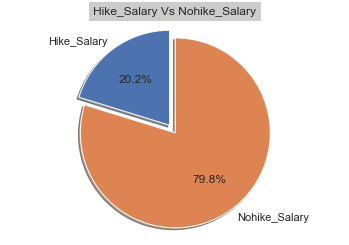

In [65]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Hike_Salary", "Nohike_Salary"]
sizes = np.array([Hike_Salary_Percentage, nohike_Salary_Percentage])
explode = (0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Hike_Salary Vs Nohike_Salary", bbox={'facecolor':'0.8', 'pad':5})

plt.show()

In [66]:
data_na_agy

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
38686,AF0U,24,K,08,13,D,2210,2,99,GG-13,L,2210,8,38,F,1,202109,1,127885.0,8.4
134010,AF1Q,40,J,10,13,G,1670,2,99,GS-13,K,XXXX,8,10,F,1,202109,1,116715.0,20.4
134011,AF1Q,40,E,13,12,E,0560,2,99,GS-12,I,XXXX,8,10,F,1,202109,1,92988.0,14.3
134012,AF1Q,40,K,04,13,J,2152,2,99,GS-13,L,XXXX,8,10,F,1,202109,1,129136.0,37.3
134013,AF1Q,40,I,04,12,F,1670,2,99,GS-12,I,XXXX,8,10,F,1,202109,1,98155.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779178,VAKB,11,D,17,11,B,343,2,99,GS-11,G,XXXX,8,15,F,1,202106,1,72750.0,1.7
1779179,VAKB,11,D,17,11,B,343,2,99,GS-11,G,XXXX,8,15,F,1,202106,1,72750.0,1.3
1779180,VAKB,11,E,13,12,A,301,2,99,GS-12,H,XXXX,8,15,F,1,202106,1,87198.0,0.8
1779181,VAKB,11,E,17,11,A,301,2,99,GS-11,G,XXXX,8,20,F,2,202106,1,72750.0,0.8


In [67]:
identical123.to_csv("identical123")
identical09 = psql.sqldf("select * from identical123 where DATECODE = 202109")
identical09.to_csv("identical09")

In [68]:
Identical123 = pd.read_csv("identical123", index_col=[0])
identical06 = Identical123[Identical123.columns.drop(list(Identical123.filter(regex='.1')))]
Identical = pd.concat([identical06, identical09], axis=0)
Identical

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,Salary_Increase
0,AF1Q,40,J,4,12,F,1670,2,99,GS-12,...,XXXX,8,10,F,1,202106,1,98155.0,17.3,0.0
1,AF1Q,40,I,13,13,I,1361,2,99,GS-13,...,1361,8,10,F,1,202106,1,119787.0,32.0,0.0
2,AF1Q,40,I,10,13,G,2150,2,99,GS-13,...,XXXX,2,10,F,1,202106,1,119787.0,20.4,0.0
3,AF1Q,40,J,14,13,H,1372,1,99,GS-13,...,1372,8,10,F,1,202106,1,119787.0,26.0,0.0
4,AF1Q,40,G,10,12,E,343,2,99,GS-12,...,XXXX,8,10,F,1,202106,1,82655.0,14.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,VAKB,11,I,15,15.0,I,301,2,99,GS-15,...,XXXX,8,10,F,1,202109,1,172500.0,30.3,0.0
1276,VAKB,11,F,13,15.0,G,343,2,99,GS-15,...,XXXX,8,15,F,1,202109,1,148932.0,21.2,0.0
1277,VAKB,11,H,13,14.0,D,301,2,99,GS-14,...,XXXX,8,10,F,1,202109,1,130698.0,9.3,4084.0
1278,VAKB,11,E,17,13.0,E,301,2,99,GS-13,...,XXXX,8,10,F,1,202109,1,103690.0,11.8,16492.0


In [91]:
FACTDATA_Agency = pd.read_csv("FEC092021/DTagy.txt")
FACTDATA_Education= pd.read_csv("FEC092021/DTedlvl.txt")
FACTDATA_Age= pd.read_csv("FEC092021/DTagelvl.txt")


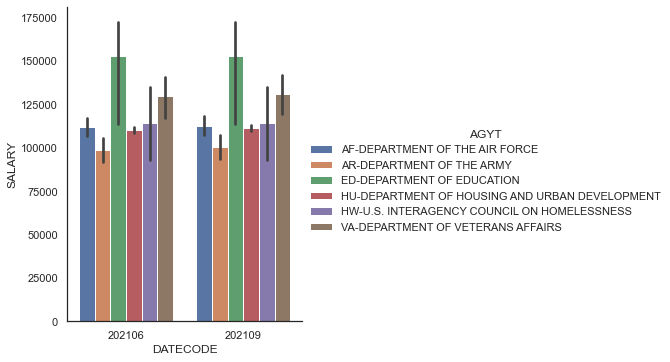

In [92]:
Identical_df = pd.merge(Identical,FACTDATA_Agency, on='AGYSUB', how='left')
Identical1_df = pd.merge(Identical_df ,FACTDATA_Education, on='EDLVL', how='left')
Identical2_df = pd.merge(Identical1_df,FACTDATA_Age, on='AGELVL', how='left')
Identical2_df.to_csv("Identical_df")
Identical123_df = pd.read_csv("Identical_df", index_col=[0])
sns.catplot(x="DATECODE", y="SALARY", hue="AGYT", kind="bar", data=Identical123_df)

In [95]:
Identical123_df

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,Salary_Increase,AGYTYP,AGYTYPT,AGY,AGYT,AGYSUBT,EDLVLTYP,EDLVLTYPT,EDLVLT,AGELVLT
0,AF1Q,40,J,4,12.0,F,1670,2,99,GS-12,...,0.0,1,Cabinet Level Agencies,AF,AF-DEPARTMENT OF THE AIR FORCE,AF1Q-HQ AF FLIGHT STANDARDS AGENCY,NaN,NaN,NaN,60-64
1,AF1Q,40,I,13,13.0,I,1361,2,99,GS-13,...,0.0,1,Cabinet Level Agencies,AF,AF-DEPARTMENT OF THE AIR FORCE,AF1Q-HQ AF FLIGHT STANDARDS AGENCY,NaN,NaN,NaN,55-59
2,AF1Q,40,I,10,13.0,G,2150,2,99,GS-13,...,0.0,1,Cabinet Level Agencies,AF,AF-DEPARTMENT OF THE AIR FORCE,AF1Q-HQ AF FLIGHT STANDARDS AGENCY,NaN,NaN,NaN,55-59
3,AF1Q,40,J,14,13.0,H,1372,1,99,GS-13,...,0.0,1,Cabinet Level Agencies,AF,AF-DEPARTMENT OF THE AIR FORCE,AF1Q-HQ AF FLIGHT STANDARDS AGENCY,NaN,NaN,NaN,60-64
4,AF1Q,40,G,10,12.0,E,343,2,99,GS-12,...,0.0,1,Cabinet Level Agencies,AF,AF-DEPARTMENT OF THE AIR FORCE,AF1Q-HQ AF FLIGHT STANDARDS AGENCY,NaN,NaN,NaN,45-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,VAKB,11,I,15,15.0,I,301,2,99,GS-15,...,0.0,1,Cabinet Level Agencies,VA,VA-DEPARTMENT OF VETERANS AFFAIRS,VAKB-DEPUTY ASSISTANT SECRETARY FOR CONGRESSIO...,6.0,POST-BACHELORS,15-FIRST PROFESSIONAL,55-59
2556,VAKB,11,F,13,15.0,G,343,2,99,GS-15,...,0.0,1,Cabinet Level Agencies,VA,VA-DEPARTMENT OF VETERANS AFFAIRS,VAKB-DEPUTY ASSISTANT SECRETARY FOR CONGRESSIO...,5.0,BACHELORS,13-BACHELOR'S DEGREE,40-44
2557,VAKB,11,H,13,14.0,D,301,2,99,GS-14,...,4084.0,1,Cabinet Level Agencies,VA,VA-DEPARTMENT OF VETERANS AFFAIRS,VAKB-DEPUTY ASSISTANT SECRETARY FOR CONGRESSIO...,5.0,BACHELORS,13-BACHELOR'S DEGREE,50-54
2558,VAKB,11,E,17,13.0,E,301,2,99,GS-13,...,16492.0,1,Cabinet Level Agencies,VA,VA-DEPARTMENT OF VETERANS AFFAIRS,VAKB-DEPUTY ASSISTANT SECRETARY FOR CONGRESSIO...,7.0,MASTERS,17-MASTER'S DEGREE,35-39


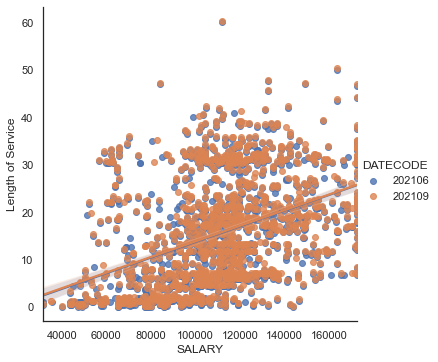

In [93]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=Identical123_df,
    x="SALARY", y="LOS", hue="DATECODE",
    height=5
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("SALARY", "Length of Service")

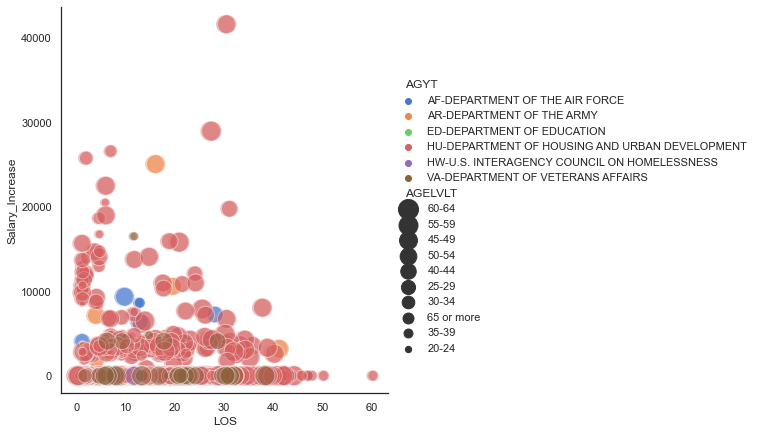

In [97]:
sns.set_theme(style="white")
sns.relplot(x="LOS", y="Salary_Increase", hue="AGYT", size="AGELVLT",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=Identical123_df)

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.


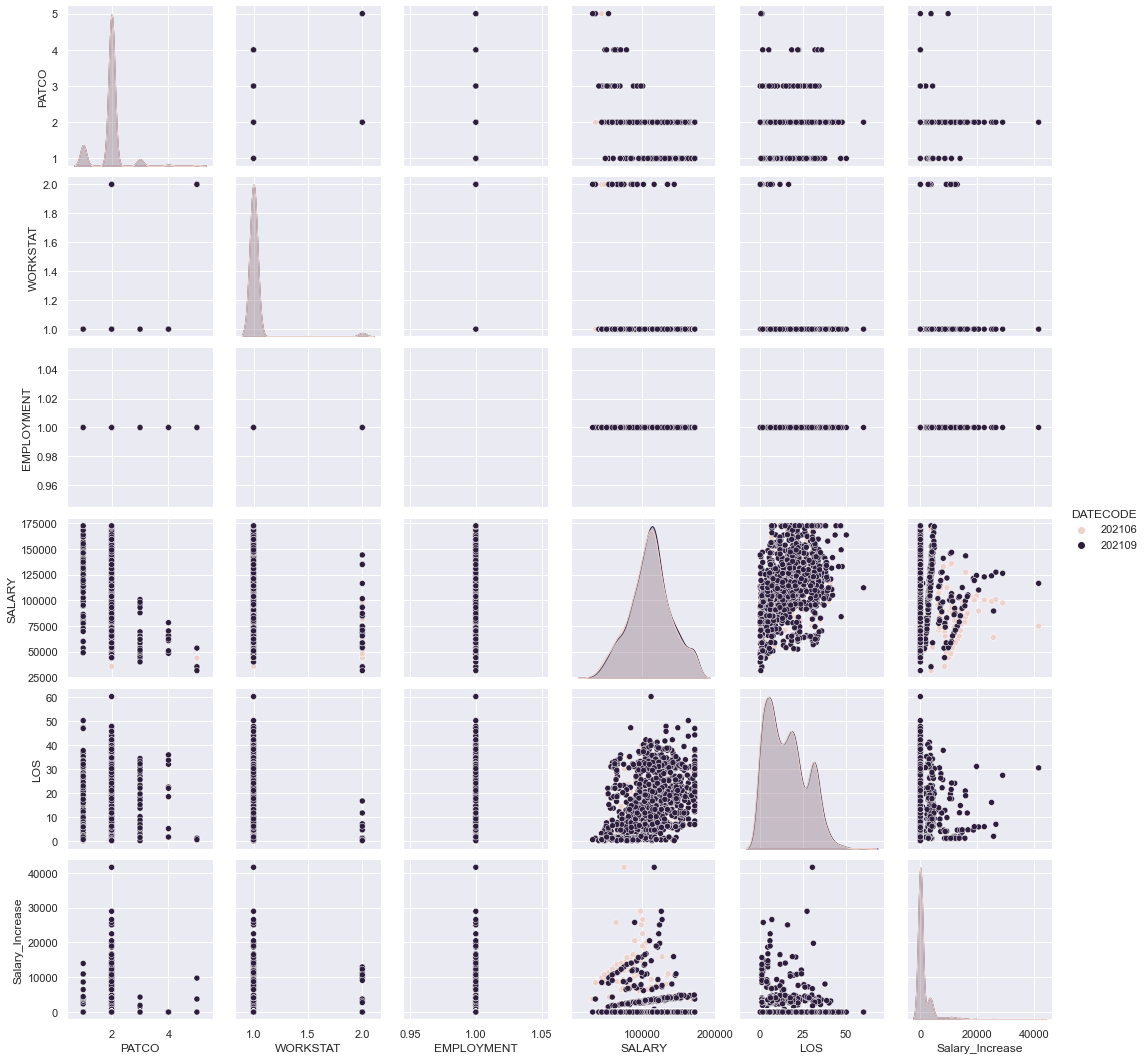

In [73]:
sns.pairplot(Identical, hue="DATECODE")